In [95]:
from __future__ import division, absolute_import, print_function
%load_ext autoreload
%autoreload 2

import os 
print(os.getcwd()) 
    
import hepran
import hepran.bzipscore as bz
import hepran.bcipa as bc
import hepran.utils as u
import hepran.registers as r
import hepran.agadir as ag

import pandas as pd
import numpy as np
import seaborn as sns
    
%matplotlib inline

import matplotlib as mpl
import matplotlib.pylab as plt

import sklearn as sk


CCO = os.environ.get("CCO",r"C:\Projekti_KI\ortoCC\CoiledCoilOrtho")

from score_utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
d:\data\ortoCC\fine_tune_scoring_function


In [96]:
from interactive_set_plot import *

import bokeh
import bokeh.resources
import bokeh.plotting as bp
from bokeh.models import HoverTool
from IPython.core.display import display, HTML
import hepran
bp.output_notebook()

import sklearn
from sklearn import linear_model
from sklearn.externals import joblib

from IPython.display import display, HTML

Loading BokehJS ...

In [108]:
%%time
df = pd.read_excel('data/round0_fiting.xlsx',index_col=[0,1])
df = df.apply(get_CC_features, axis=1)

Wall time: 1.12 s


In [109]:
basicL = 'c_NN c_IN c_II es_EE es_EK es_KK cd_LL'.split()
basicCP = ['EEIIEE','EEINEE','EENNEE','EKIIEK','EKINEK','EKNIEK','EKNNEK','KKIIKK','KKINKK','KKNNKK']
#check KK counting
all((df.es_EE + df.es_EK + df.es_KK) == 8)
bs = df["seq1 seq2".split()+basicL]



In [110]:
#get all the heptades that appear
useqs = bs.seq1.append(bs.seq2, ignore_index=True).unique()
heps = [r.get_gade(seq) for seq in useqs]
import itertools
import collections
heps = list(itertools.chain(*heps))
collections.Counter(heps)

Counter({'EILE': 24, 'ENLE': 24, 'KILK': 24, 'KNLK': 24})

In [111]:
bs[basicL].sum()

c_NN     184
c_IN     320
c_II     184
es_EE    368
es_EK    640
es_KK    368
cd_LL    688
dtype: int64

In [112]:

def get_all_crosspairs_same_ge():
    """Returns all posible crosspair combinations. Currently same GE only"""
    l = []
    for e1 in list('KE'):
        for e2 in list('KE'):
            for c1 in list('NI'):
                for c2 in list('NI'):
                    l.append(e1+e2+c1+c2+e1+e2)          
    l=sorted(l)
    #remove palindromes
    filt = []
    for hep in l:
        if (hep in filt) or (hep[::-1] in filt):
            continue
        else:
            filt.append(hep)
    return filt      

display(get_all_crosspairs_same_ge())

def get_all_crosspairs():
    """Returns all posible crosspair combinations"""
    l = []
    for e1 in list('KE'):
        for e2 in list('KE'):
            for c1 in list('NI'):
                for c2 in list('NI'):
                    for e3 in list('KE'):
                        for e4 in list('KE'):
                            l.append(e1+e2+c1+c2+e3+e4)          
    l=sorted(l)
    #remove palindromes
    filt = []
    for hep in l:
        if (hep in filt) or (hep[::-1] in filt):
            continue
        else:
            filt.append(hep)
    return filt      

display(get_all_crosspairs())

['EEIIEE',
 'EEINEE',
 'EENNEE',
 'EKIIEK',
 'EKINEK',
 'EKNIEK',
 'EKNNEK',
 'KKIIKK',
 'KKINKK',
 'KKNNKK']

['EEIIEE',
 'EEIIEK',
 'EEIIKE',
 'EEIIKK',
 'EEINEE',
 'EEINEK',
 'EEINKE',
 'EEINKK',
 'EENIEK',
 'EENIKE',
 'EENIKK',
 'EENNEE',
 'EENNEK',
 'EENNKE',
 'EENNKK',
 'EKIIEK',
 'EKIIKE',
 'EKIIKK',
 'EKINEK',
 'EKINKE',
 'EKINKK',
 'EKNIEK',
 'EKNIKK',
 'EKNNEK',
 'EKNNKE',
 'EKNNKK',
 'KEIIEK',
 'KEIIKK',
 'KEINEK',
 'KEINKK',
 'KENIKK',
 'KENNEK',
 'KENNKK',
 'KKIIKK',
 'KKINKK',
 'KKNNKK']

In [126]:
basicCP = 'cp_EEIIEE cp_EEINEE cp_EENNEE cp_EKIIEK cp_EKINEK cp_EKNIEK cp_EKNNEK cp_KKIIKK cp_KKINKK cp_KKNNKK'.split()
#df["seq1 seq2".split()+basicCP].sum()
df[basicCP].sum()

cp_EEIIEE    52
cp_EEINEE    80
cp_EENNEE    52
cp_EKIIEK    80
cp_EKINEK    80
cp_EKNIEK    80
cp_EKNNEK    80
cp_KKIIKK    52
cp_KKINKK    80
cp_KKNNKK    52
dtype: int64

In [87]:
fit_type_string = "basicL-rep-nter_core"
lm_type = "BayesianRidge" #Ridge, ElasticNet, SGDRegressor, BayesianRidge
weight_string="W1" #W1 W10 W10L15H50 W10L15H55

#read ENV vars if they are set
fit_type_string = os.environ.get('fit_type_string', fit_type_string)
lm_type = os.environ.get('lm_type', lm_type)
weight_string = os.environ.get('weight_string', weight_string)

In [88]:
def get_FIT_dataframe(df, lm, N_iter, fit_type, N_feat, N_samples):
    r = get_metrics_df()
    
    Q=df
    r=r.append(
        get_FIT_metrics(Q.Tm, Q.score, Q.weights, N_iter, fit_type, fit_class='all', N_feat=len(lm.coef_)+1, N_samples=len(Q)) ,
        ignore_index=True)
    
    Q=df.query('Tm>25')
    r=r.append(
        get_FIT_metrics(Q.Tm, Q.score, Q.weights, N_iter, fit_type, fit_class='Tm>25', N_feat=len(lm.coef_)+1, N_samples=len(Q)) ,
        ignore_index=True)

    Q=df.query('Tm>55')
    r=r.append(
        get_FIT_metrics(Q.Tm, Q.score, Q.weights, N_iter, fit_type, fit_class='Tm>55', N_feat=len(lm.coef_)+1, N_samples=len(Q)) ,
        ignore_index=True)
    
    Q=df.query('on_target')
    r=r.append(
        get_FIT_metrics(Q.Tm, Q.score, Q.weights, N_iter, fit_type, fit_class='on_target', N_feat=len(lm.coef_)+1, N_samples=len(Q)) ,
        ignore_index=True)
    
    r = r.set_index('N_iter fit_type fit_class'.split())
    return r                

Iteration:  0
Num points:  172


corrR  R2_score  \
N_iter fit_type                              fit_class                       
0      basicL-rep-nter_core-W1-BayesianRidge all        0.715873  0.511972   
                                             Tm>25      0.653712  0.195591   
                                             Tm>55      0.692982 -5.482960   
                                             on_target  0.474531 -4.639924   

                                                             RMSE  \
N_iter fit_type                              fit_class              
0      basicL-rep-nter_core-W1-BayesianRidge all        12.308976   
                                             Tm>25      12.015219   
                                             Tm>55      15.483450   
                                             on_target  14.730255   

                                                        med_abs_err  \
N_iter fit_type                              fit_class                
0      basicL-rep-nter_core-W1-BayesianRidge all           2.901844   
                                             Tm>25         2.849416   
                                             Tm>55         3.773309   
                                             on_target     3.658143   

                                                        explained_var  \
N_iter fit_type                              fit_class                  
0      basicL-rep-nter_core-W1-BayesianRidge all             0.511972   
                                             Tm>25           0.411260   
                                             Tm>55           0.141671   
                                             on_target      -0.075859   

                                                        Baysian_IC  \
N_iter fit_type                              fit_class               
0      basicL-rep-nter_core-W1-BayesianRidge all        925.323024   
                                             Tm>25      527.019600   
                                             Tm>55      108.382295   
                                             on_target   94.376565   

                                                          Akaike_IC N_samples  \
N_iter fit_type                              fit_class                          
0      basicL-rep-nter_core-W1-BayesianRidge all        1772.922141       172   
                                             Tm>25       928.991382        95   
                                             Tm>55       137.660410        14   
                                             on_target   118.376565        12   

                                                       N_feat  
N_iter fit_type                              fit_class         
0      basicL-rep-nter_core-W1-BayesianRidge all           12  
                                             Tm>25         12  
                                             Tm>55         12  
                                             on_target     12

feature  \
N_iter fit_type                                                     
0      basicL-rep-nter_core-W1-BayesianRidge                 c_NN   
       basicL-rep-nter_core-W1-BayesianRidge                 c_IN   
       basicL-rep-nter_core-W1-BayesianRidge                 c_II   
       basicL-rep-nter_core-W1-BayesianRidge                es_EE   
       basicL-rep-nter_core-W1-BayesianRidge                es_EK   
       basicL-rep-nter_core-W1-BayesianRidge                es_KK   
       basicL-rep-nter_core-W1-BayesianRidge                cd_LL   
       basicL-rep-nter_core-W1-BayesianRidge  interface_repulsion   
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_NN   
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_IN   
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_II   

                                                      coef  
N_iter fit_type                                             
0      basicL-rep-nter_core-W1-BayesianRidge  1.131372e+00  
       basicL-rep-nter_core-W1-BayesianRidge -2.262745e+00  
       basicL-rep-nter_core-W1-BayesianRidge  1.131372e+00  
       basicL-rep-nter_core-W1-BayesianRidge -1.968548e+00  
       basicL-rep-nter_core-W1-BayesianRidge  1.868430e+00  
       basicL-rep-nter_core-W1-BayesianRidge  1.001182e-01  
       basicL-rep-nter_core-W1-BayesianRidge -4.198616e-14  
       basicL-rep-nter_core-W1-BayesianRidge -3.974169e-01  
       basicL-rep-nter_core-W1-BayesianRidge  3.846642e+00  
       basicL-rep-nter_core-W1-BayesianRidge  7.114137e-01  
       basicL-rep-nter_core-W1-BayesianRidge -4.558055e+00

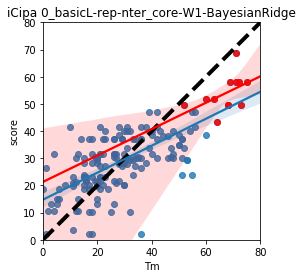

In [89]:


fit_type = fit_type_string
fit_fields = fit_fields_dic[fit_type_string]

set_weights(weight_string, df)
if weight_string:
    fit_type += "-" + weight_string


Q=df
N_iter = 0
print("Iteration: ", N_iter)
print("Num points: ", len(Q))
lm, R2 = make_model('Tm', fit_fields, Q, lm_type)
fit_type += "-" + lm_type 

df['score'] = lm.predict(df[fit_fields])
df['pos'] = 0



df = df.apply(get_formated_seq, axis=1)
df['IDs']=df.index
title = str(N_iter)+"_"+fit_type
#bp.output_file(title=title, filename='models\\{title}.plot.html'.format(**locals()))
p = draw_scatter_interactive('Tm','score',df, y_range=(0,80),                                
                                 title=title, save_to_file=False)


bp.show(p)

mpl_plot_fit(title, df)

fit_metric = get_FIT_dataframe(Q, lm, N_iter, fit_type, N_feat=len(lm.coef_)+1, N_samples=len(Q))
fit_metrics_all = fit_metrics_all.append(fit_metric)
display(fit_metric)
model_features = get_model_features(lm, fit_fields, N_iter, fit_type)
model_features_all = model_features_all.append(model_features)
display(model_features)



joblib.dump(lm, 'models/{title}.model'.format(**locals())); 
df.to_excel('models/{title}.score.xlsx'.format(**locals()));
bp.save(p, title=title, filename='models\\{title}.plot.html'.format(**locals()), resources=bokeh.resources.INLINE);

corrR  R2_score  \
N_iter fit_type                              fit_class                       
1      basicL-rep-nter_core-W1-BayesianRidge all        0.800313  0.640103   
                                             Tm>25      0.767597  0.410794   
                                             Tm>55      0.804969 -2.503739   
                                             on_target  0.472773 -0.900778   

                                                             RMSE  \
N_iter fit_type                              fit_class              
1      basicL-rep-nter_core-W1-BayesianRidge all        10.570336   
                                             Tm>25      10.283162   
                                             Tm>55      11.382744   
                                             on_target   8.551441   

                                                        med_abs_err  \
N_iter fit_type                              fit_class                
1      basicL-rep-nter_core-W1-BayesianRidge all           2.699918   
                                             Tm>25         2.708201   
                                             Tm>55         3.173843   
                                             on_target     2.798992   

                                                        explained_var  \
N_iter fit_type                              fit_class                  
1      basicL-rep-nter_core-W1-BayesianRidge all             0.640103   
                                             Tm>25           0.561844   
                                             Tm>55           0.008133   
                                             on_target       0.154089   

                                                        Baysian_IC  \
N_iter fit_type                              fit_class               
1      basicL-rep-nter_core-W1-BayesianRidge all        872.939694   
                                             Tm>25      497.443013   
                                             Tm>55       99.767446   
                                             on_target   81.325275   

                                                          Akaike_IC N_samples  \
N_iter fit_type                              fit_class                          
1      basicL-rep-nter_core-W1-BayesianRidge all        1720.538811       172   
                                             Tm>25       899.414795        95   
                                             Tm>55       129.045561        14   
                                             on_target   105.325275        12   

                                                       N_feat  
N_iter fit_type                              fit_class         
1      basicL-rep-nter_core-W1-BayesianRidge all           12  
                                             Tm>25         12  
                                             Tm>55         12  
                                             on_target     12

feature      coef
N_iter fit_type                                                            
1      basicL-rep-nter_core-W1-BayesianRidge                 c_NN -0.079931
       basicL-rep-nter_core-W1-BayesianRidge                 c_IN -3.910362
       basicL-rep-nter_core-W1-BayesianRidge                 c_II  5.755609
       basicL-rep-nter_core-W1-BayesianRidge                es_EE -1.363943
       basicL-rep-nter_core-W1-BayesianRidge                es_EK  4.107971
       basicL-rep-nter_core-W1-BayesianRidge                es_KK  0.786604
       basicL-rep-nter_core-W1-BayesianRidge                cd_LL  1.765316
       basicL-rep-nter_core-W1-BayesianRidge  interface_repulsion -0.289726
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_NN  2.389003
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_IN  0.960920
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_II -3.349923

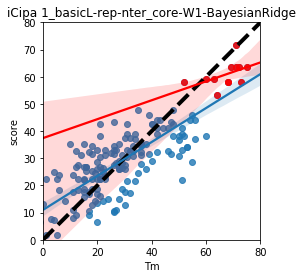

In [91]:
N_iter = 1
seqs = df

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                              fit_class                       
2      basicL-rep-nter_core-W1-BayesianRidge all        0.824645  0.679701   
                                             Tm>25      0.787529  0.453309   
                                             Tm>55      0.760479 -1.409530   
                                             on_target  0.467248 -0.324342   

                                                            RMSE  med_abs_err  \
N_iter fit_type                              fit_class                          
2      basicL-rep-nter_core-W1-BayesianRidge all        9.971889     2.568718   
                                             Tm>25      9.905217     2.502987   
                                             Tm>55      9.439461     2.758103   
                                             on_target  7.137952     2.349552   

                                                        explained_var  \
N_iter fit_type                              fit_class                  
2      basicL-rep-nter_core-W1-BayesianRidge all             0.679701   
                                             Tm>25           0.578144   
                                             Tm>55          -0.134406   
                                             on_target       0.075041   

                                                        Baysian_IC  \
N_iter fit_type                              fit_class               
2      basicL-rep-nter_core-W1-BayesianRidge all        852.890838   
                                             Tm>25      490.328218   
                                             Tm>55       94.525856   
                                             on_target   76.989102   

                                                          Akaike_IC N_samples  \
N_iter fit_type                              fit_class                          
2      basicL-rep-nter_core-W1-BayesianRidge all        1700.489955       172   
                                             Tm>25       892.300000        95   
                                             Tm>55       123.803971        14   
                                             on_target   100.989102        12   

                                                       N_feat  
N_iter fit_type                              fit_class         
2      basicL-rep-nter_core-W1-BayesianRidge all           12  
                                             Tm>25         12  
                                             Tm>55         12  
                                             on_target     12

feature       coef
N_iter fit_type                                                             
2      basicL-rep-nter_core-W1-BayesianRidge                 c_NN  -3.579618
       basicL-rep-nter_core-W1-BayesianRidge                 c_IN  -4.876579
       basicL-rep-nter_core-W1-BayesianRidge                 c_II  10.873436
       basicL-rep-nter_core-W1-BayesianRidge                es_EE  -1.123796
       basicL-rep-nter_core-W1-BayesianRidge                es_EK   4.889348
       basicL-rep-nter_core-W1-BayesianRidge                es_KK   1.068928
       basicL-rep-nter_core-W1-BayesianRidge                cd_LL   2.417240
       basicL-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.287810
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.618878
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_IN   1.721451
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.340329

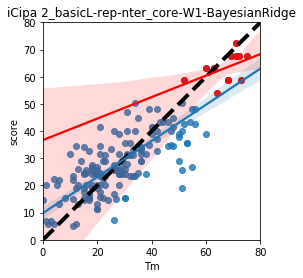

In [93]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                              fit_class                       
3      basicL-rep-nter_core-W1-BayesianRidge all        0.827226  0.683976   
                                             Tm>25      0.788507  0.459678   
                                             Tm>55      0.752108 -1.379437   
                                             on_target  0.462575 -0.319761   

                                                            RMSE  med_abs_err  \
N_iter fit_type                              fit_class                          
3      basicL-rep-nter_core-W1-BayesianRidge all        9.905116     2.550409   
                                             Tm>25      9.847348     2.532306   
                                             Tm>55      9.380331     2.697448   
                                             on_target  7.125597     2.305304   

                                                        explained_var  \
N_iter fit_type                              fit_class                  
3      basicL-rep-nter_core-W1-BayesianRidge all             0.683976   
                                             Tm>25           0.579371   
                                             Tm>55          -0.158750   
                                             on_target       0.058994   

                                                        Baysian_IC  \
N_iter fit_type                              fit_class               
3      basicL-rep-nter_core-W1-BayesianRidge all        850.579625   
                                             Tm>25      489.214936   
                                             Tm>55       94.349909   
                                             on_target   76.947523   

                                                          Akaike_IC N_samples  \
N_iter fit_type                              fit_class                          
3      basicL-rep-nter_core-W1-BayesianRidge all        1698.178742       172   
                                             Tm>25       891.186718        95   
                                             Tm>55       123.628024        14   
                                             on_target   100.947523        12   

                                                       N_feat  
N_iter fit_type                              fit_class         
3      basicL-rep-nter_core-W1-BayesianRidge all           12  
                                             Tm>25         12  
                                             Tm>55         12  
                                             on_target     12

feature       coef
N_iter fit_type                                                             
3      basicL-rep-nter_core-W1-BayesianRidge                 c_NN  -4.356632
       basicL-rep-nter_core-W1-BayesianRidge                 c_IN  -4.945642
       basicL-rep-nter_core-W1-BayesianRidge                 c_II  11.842840
       basicL-rep-nter_core-W1-BayesianRidge                es_EE  -1.049083
       basicL-rep-nter_core-W1-BayesianRidge                es_EK   4.964110
       basicL-rep-nter_core-W1-BayesianRidge                es_KK   1.166104
       basicL-rep-nter_core-W1-BayesianRidge                cd_LL   2.540566
       basicL-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.281874
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.981547
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_IN   1.408053
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.389600

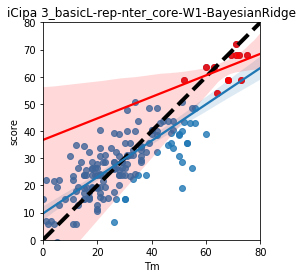

In [95]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                              fit_class                       
4      basicL-rep-nter_core-W1-BayesianRidge all        0.827126  0.683810   
                                             Tm>25      0.788257  0.461352   
                                             Tm>55      0.752892 -1.405495   
                                             on_target  0.460453 -0.293333   

                                                            RMSE  med_abs_err  \
N_iter fit_type                              fit_class                          
4      basicL-rep-nter_core-W1-BayesianRidge all        9.907710     2.569810   
                                             Tm>25      9.832089     2.493305   
                                             Tm>55      9.431554     2.702425   
                                             on_target  7.053892     2.301611   

                                                        explained_var  \
N_iter fit_type                              fit_class                  
4      basicL-rep-nter_core-W1-BayesianRidge all             0.683810   
                                             Tm>25           0.580241   
                                             Tm>55          -0.195854   
                                             on_target       0.060975   

                                                        Baysian_IC  \
N_iter fit_type                              fit_class               
4      basicL-rep-nter_core-W1-BayesianRidge all        850.669674   
                                             Tm>25      488.920288   
                                             Tm>55       94.502392   
                                             on_target   76.704788   

                                                          Akaike_IC N_samples  \
N_iter fit_type                              fit_class                          
4      basicL-rep-nter_core-W1-BayesianRidge all        1698.268790       172   
                                             Tm>25       890.892070        95   
                                             Tm>55       123.780506        14   
                                             on_target   100.704788        12   

                                                       N_feat  
N_iter fit_type                              fit_class         
4      basicL-rep-nter_core-W1-BayesianRidge all           12  
                                             Tm>25         12  
                                             Tm>55         12  
                                             on_target     12

feature       coef
N_iter fit_type                                                             
4      basicL-rep-nter_core-W1-BayesianRidge                 c_NN  -4.253987
       basicL-rep-nter_core-W1-BayesianRidge                 c_IN  -4.706696
       basicL-rep-nter_core-W1-BayesianRidge                 c_II  11.606045
       basicL-rep-nter_core-W1-BayesianRidge                es_EE  -0.996763
       basicL-rep-nter_core-W1-BayesianRidge                es_EK   5.090353
       basicL-rep-nter_core-W1-BayesianRidge                es_KK   1.197135
       basicL-rep-nter_core-W1-BayesianRidge                cd_LL   2.645363
       basicL-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.275627
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_NN   4.077514
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_IN   1.250151
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.327664

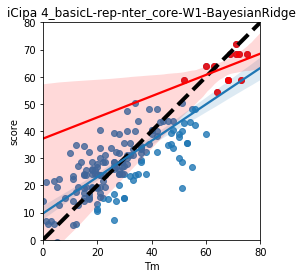

In [97]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

corrR  R2_score  \
N_iter fit_type                              fit_class                       
5      basicL-rep-nter_core-W1-BayesianRidge all        0.827168  0.683879   
                                             Tm>25      0.788389  0.456837   
                                             Tm>55      0.752550 -1.416664   
                                             on_target  0.463430 -0.348622   

                                                            RMSE  med_abs_err  \
N_iter fit_type                              fit_class                          
5      basicL-rep-nter_core-W1-BayesianRidge all        9.906630     2.577255   
                                             Tm>25      9.873208     2.490353   
                                             Tm>55      9.453424     2.737088   
                                             on_target  7.203088     2.314735   

                                                        explained_var  \
N_iter fit_type                              fit_class                  
5      basicL-rep-nter_core-W1-BayesianRidge all             0.683879   
                                             Tm>25           0.577805   
                                             Tm>55          -0.143204   
                                             on_target       0.063188   

                                                        Baysian_IC  \
N_iter fit_type                              fit_class               
5      basicL-rep-nter_core-W1-BayesianRidge all        850.632183   
                                             Tm>25      489.713237   
                                             Tm>55       94.567245   
                                             on_target   77.207116   

                                                          Akaike_IC N_samples  \
N_iter fit_type                              fit_class                          
5      basicL-rep-nter_core-W1-BayesianRidge all        1698.231299       172   
                                             Tm>25       891.685019        95   
                                             Tm>55       123.845360        14   
                                             on_target   101.207116        12   

                                                       N_feat  
N_iter fit_type                              fit_class         
5      basicL-rep-nter_core-W1-BayesianRidge all           12  
                                             Tm>25         12  
                                             Tm>55         12  
                                             on_target     12

feature       coef
N_iter fit_type                                                             
5      basicL-rep-nter_core-W1-BayesianRidge                 c_NN  -4.077848
       basicL-rep-nter_core-W1-BayesianRidge                 c_IN  -5.162530
       basicL-rep-nter_core-W1-BayesianRidge                 c_II  11.497833
       basicL-rep-nter_core-W1-BayesianRidge                es_EE  -1.208977
       basicL-rep-nter_core-W1-BayesianRidge                es_EK   4.778290
       basicL-rep-nter_core-W1-BayesianRidge                es_KK   0.945598
       basicL-rep-nter_core-W1-BayesianRidge                cd_LL   2.257456
       basicL-rep-nter_core-W1-BayesianRidge  interface_repulsion  -0.282358
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_NN   3.843515
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_IN   1.596974
       basicL-rep-nter_core-W1-BayesianRidge           nterm_c_II  -5.440489

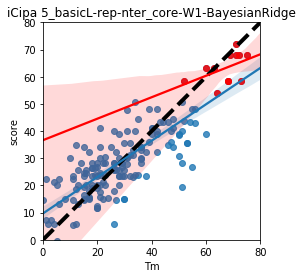

In [99]:
seqs['seq1'] = df['seq1']
seqs['seq2'] = df['seq2']
N_iter += 1

%run -i 08_aligned_fit_DO_ITER.py

In [101]:
fit_metrics_all.to_csv('models/{fit_type}.metrics.csv'.format(**locals()) ) 
model_features_all.to_csv('models/{fit_type}.metrics.csv'.format(**locals()) ) 